Importing the Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


Data Visualization


In [9]:
path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_scc', 'lung_n']

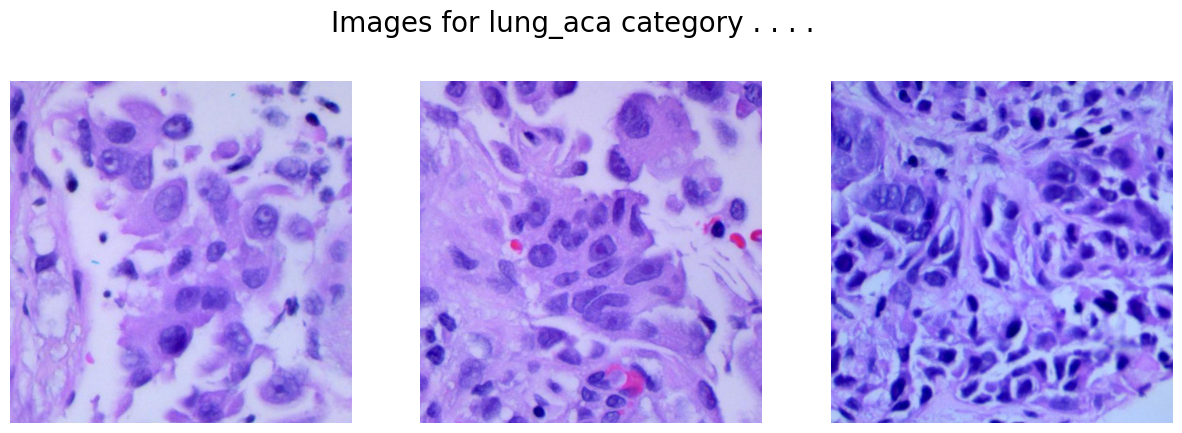

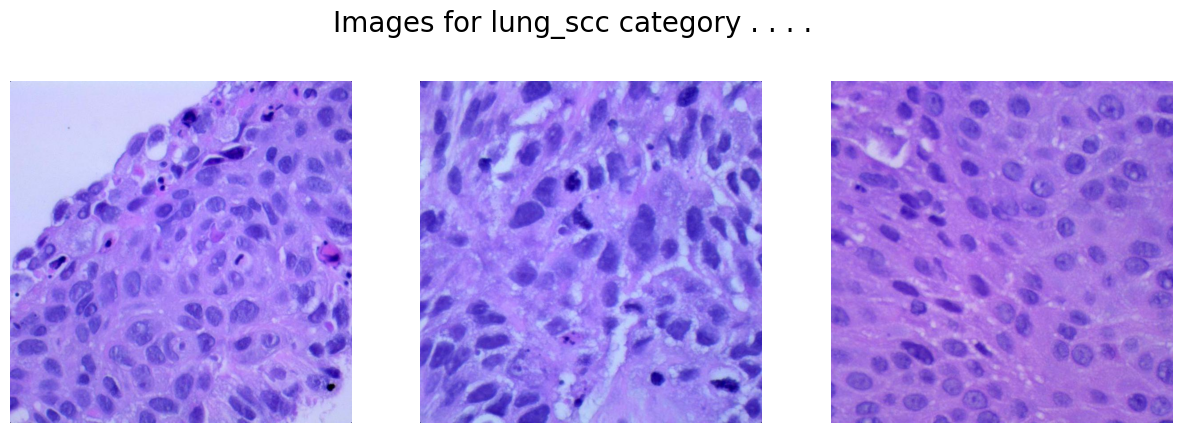

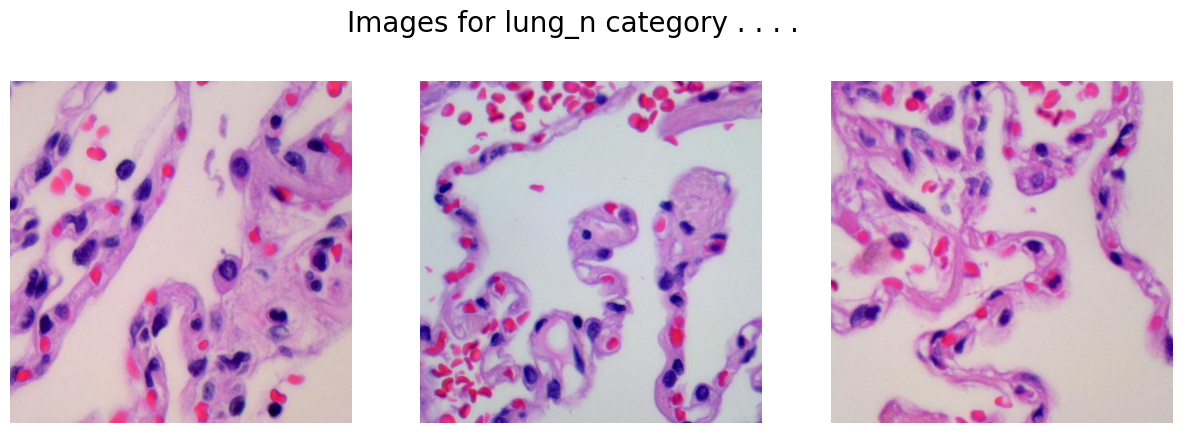

In [10]:
for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize = (15, 5))
	fig.suptitle(f'Images for {cat} category . . . .',
				fontsize = 20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


Data Preparation

In [11]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [12]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


Model Development

In [15]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
 
pre_trained_model = InceptionV3(
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    weights = 'imagenet',
    include_top = False
)

In [16]:
len(pre_trained_model.layers)

311

In [17]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [18]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 768)


In [19]:
x = layers.Flatten()(last_output)

x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation='softmax')(x)

#Creating the Model
model = keras.Model(pre_trained_model.input, output)

In [20]:
model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

Training the model

In [22]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - 1174s 6s/step - loss: 0.3760 - accuracy: 0.8506 - val_loss: 1.2273 - val_accuracy: 0.5747 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 1161s 6s/step - loss: 0.2286 - accuracy: 0.9099 - val_loss: 0.3637 - val_accuracy: 0.8627 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 1166s 6s/step - loss: 0.1772 - accuracy: 0.9317 - val_loss: 0.3373 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 1160s 6s/step - loss: 0.1371 - accuracy: 0.9470 - val_loss: 0.5651 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.9518
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 1163s 6s/step - loss: 0.1246 - accuracy: 0.9518 - val_loss: 0.5666 - val_accuracy: 0.8143 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 

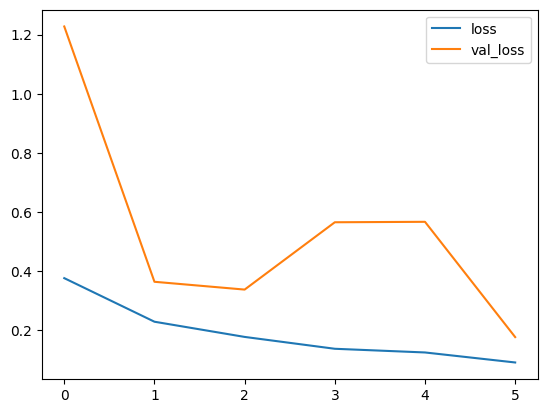

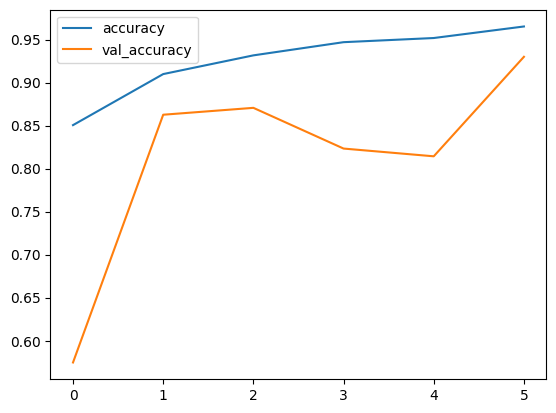

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

Model Evaluation

In [24]:
Y_pred = model.predict(X_val)
 
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 199s 2s/step


In [25]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[ 838,   60,   89],
       [  55,  916,    6],
       [   0,    0, 1036]])

In [26]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.94      0.85      0.89       987
    lung_scc       0.94      0.94      0.94       977
      lung_n       0.92      1.00      0.96      1036

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

